In [1]:
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.io import loadmat
from scipy.special import gamma
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.patches as patches
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

In [2]:
def embedding_fit_metrics(original_distances, embedded_distances):
    """
    Computes the following goodness-of-fit metrics for an embedding:
    1. Spearman's Rank Correlation
    2. Pearson Correlation
    3. R^2 value (MSE to the line y = x)

    Parameters:
    original_distances (array-like): Pairwise distances in the original space.
    embedded_distances (array-like): Pairwise distances in the embedded space.

    Returns:
    dict: A dictionary containing Spearman's rho, Pearson's r, and R^2 value.
    """
    
    # Ensure input is NumPy arrays
    original_distances = np.array(original_distances)
    embedded_distances = np.array(embedded_distances)
    
    # Compute Spearman's rank correlation
    spearman_corr, _ = spearmanr(original_distances, embedded_distances)
    
    # Compute Pearson correlation
    pearson_corr, _ = pearsonr(original_distances, embedded_distances)
    
    # Compute R^2 value (MSE to the line y = x)
    r2 = r2_score(original_distances, embedded_distances)
    
    return {
        "Spearman Rank Correlation": spearman_corr,
        "Pearson Correlation": pearson_corr,
        "R^2 Value": r2
    }

In [3]:
def vol(R, D):
    c = 2*np.power(np.pi, 0.5*D)
    itg = integrate.quad(lambda x: np.power(np.sinh(x), D-1), 0.0, R)[0]
    return c*itg

def sample_r(R, D):
    rmin = 0.0; rmax = R; rc = 0.5*R
    V_tot = vol(R, D); uc = vol(rc, D)/V_tot
    u = np.random.uniform()
    while(np.abs(u-uc)>1e-4):
        if uc < u:
            rmin = rc
            rc = 0.5*(rc + rmax)
            uc = vol(rc, D)/V_tot
        elif u < uc:
            rmax = rc
            rc = 0.5*(rc + rmin)
            uc = vol(rc, D)/V_tot
    return rc

#uniformly sample a point in hyperbolic space out to Rmax
#return point in poincare coords
def h_samp(rm, D):
    direction = np.random.normal(size=D)
    direction = direction/np.sqrt(np.sum(np.square(direction)))
    #th = 2.0*np.pi*np.random.uniform()
    r_p = sample_r(rm, 2)
    return np.tanh(r_p/2.0)*direction
    #return np.tanh(r_p/2.0)*np.asarray([np.cos(th), np.sin(th)])

def pdist(p1, p2):
    inv = 2.0*(p1-p2).dot(p1-p2)/((1-p1.dot(p1))*(1-p2.dot(p2)))
    return np.arccosh(1.0 + inv)


In [4]:
class HMDS():
    def __init__(self, deltaij, D, a=2, b=0.5, sig_lam=10, tolerance=1e-10):
        ## Parameters ##
        self.deltaij = tf.constant(deltaij, dtype=tf.float32)
        self.N = tf.constant(deltaij.shape[0])
        self.D = tf.constant(D)

        ## Variables ##
        self.euc = tf.Variable(tf.random.normal(shape=(self.N, self.D), mean=0.0, stddev=.0001), dtype=tf.float32)
        self.log_sig = tf.Variable(tf.random.normal(shape=(self.N,1), mean=0, stddev=0.001), dtype=tf.float32)
        self.log_lam = tf.Variable(0, dtype=tf.float32)

        ## Constraints ##
        self.time = tf.Variable(tf.random.normal(shape=(self.N,1), mean=0, stddev=0.001), shape=(self.N,1), trainable=False)

        ## Model Hyperparameters ##
        self.a = a
        self.b = b
        self.sig_lam = sig_lam

        ## Optimization Hyperparameters ##
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
        self.tolerance = tolerance

        ## Optimization Results ##
        self.loss_curve = []
        self.lambda_curve = []
        
    @tf.function
    def constraint_time(self):
        return tf.expand_dims(tf.sqrt(tf.add(1.0,tf.square(tf.norm(self.euc,axis=1)))),1)

    @tf.function
    def pairwise_dist_lorentz(self):
        self.time = self.constraint_time()
        time_product = tf.matmul(self.time, self.time, transpose_b=True)
        space_product = tf.matmul(self.euc, self.euc, transpose_b=True)
        lorentzian_inner_product = time_product - space_product
        lorentzian_inner_product_clipped = tf.maximum(lorentzian_inner_product, 1.0+1e-7)
        distance_matrix = tf.math.acosh(lorentzian_inner_product_clipped) + 1e-12
        return distance_matrix
        
    @tf.function
    def loss(self):
        dist = self.pairwise_dist_lorentz()
        s2 = tf.transpose(tf.square(tf.math.exp(self.log_sig))) + tf.square(tf.math.exp(self.log_sig)) + 1e-12
        stress = tf.divide(tf.square(tf.divide(dist,tf.math.exp(self.log_lam)) - self.deltaij),s2)
        lkl = tf.add(stress, tf.math.log(tf.scalar_mul(2*np.pi, s2)))
        mask = tf.cast(tf.linalg.band_part(tf.ones_like(lkl),0, -1) - tf.eye(tf.shape(lkl)[0]), dtype=tf.bool)
        lkl_upper = tf.boolean_mask(lkl,mask)
        prior_lam = tf.scalar_mul(tf.divide(tf.cast(self.N*(self.N-1),tf.float32),4*(self.sig_lam**2)),tf.math.exp(self.log_lam)**2)
        prior_sig = tf.reduce_sum(tf.scalar_mul((self.a + 1), self.log_sig) + tf.divide(self.b, tf.math.exp(self.log_sig)))
        return 0.5*tf.reduce_sum(lkl_upper) + prior_lam + prior_sig + tf.reduce_sum(self.log_sig) + self.log_lam

    @tf.function
    def train_step(self):
        with tf.GradientTape() as tape:
            loss_value = self.loss()
        grads = tape.gradient(loss_value, [self.euc, self.log_sig, self.log_lam])
        self.optimizer.apply_gradients(zip(grads, [self.euc, self.log_sig, self.log_lam]))
        gradient_norm = tf.reduce_sum([tf.reduce_sum(tf.square(g)) for g in grads])
        return loss_value, gradient_norm

    def train(self, n=50000):
        for epoch in range(n):
            loss_val, gradient_norm = self.train_step()
            self.loss_curve.append(loss_val)
            self.lambda_curve.append(np.exp(self.log_lam.numpy()))
            if epoch % 5000 == 0:
                print(f'epoch {epoch}, Loss: {loss_val.numpy()}, normG: {gradient_norm.numpy()}')
            if gradient_norm < self.tolerance:
                print(f"Converged at epoch {epoch + 1}, Loss: {loss_val.numpy()}, normG: {gradient_norm.numpy()}")
                break  # Stop training

    ## Visualization ##
    def plot_loss(self):
        plt.figure()
        plt.plot(self.loss_curve)
        plt.xlabel('Step')
        plt.ylabel('-Log Likelihood')
        plt.show()

    def plot_lambda(self):
        plt.figure()
        plt.plot(self.lambda_curve)
        plt.xlabel('Step')
        plt.ylabel('Lambda')
        plt.show()

    def plot_sigmas(self):
        plt.figure()
        plt.hist(np.exp(self.log_sig.numpy()))
        plt.xlabel('Sigma')
        plt.ylabel('Counts')
        plt.show()

    def shepard(self):
        plt.figure()
        plt.scatter(self.deltaij.numpy()[np.triu_indices(self.N,k=1)], self.pairwise_dist_lorentz().numpy()[np.triu_indices(self.N,k=1)]/np.exp(self.log_lam))
        plt.xlabel('True Distance')
        plt.ylabel('Embedding Distance')
        plt.show()

    

    def get_poin(self):
        ts = np.sqrt(1.0 + np.sum(np.square(self.euc.numpy()), axis=1))
        p_coords = (self.euc.numpy().T / (ts + 1)).T
        return p_coords

    ## Metrics ##
    def MDS_lkl(self):
        lkl = 0
        dmat = self.deltaij.numpy()
        N = self.N.numpy()
        sigs = np.exp(self.log_sig.numpy())
        lam = np.exp(self.log_lam.numpy())
        emb_mat = self.pairwise_dist_lorentz().numpy()
        
        for i in np.arange(N):
            for j in np.arange(i+1, N):
                seff = sigs[i]**2 + sigs[j]**2
                lkl += ((dmat[i][j] - emb_mat[i][j]/lam)**2 / (2.0*seff)) + 0.5*np.log(seff*2.0*np.pi)
        return lkl[0]

    def BIC(self):
        N, D = self.N.numpy(), self.D.numpy()
        n = 0.5*N*(N-1)
        k = N*D + N + 1.0 - 0.5*D*(D-1)
        return float(k*np.log(n) + 2.0*self.MDS_lkl())


In [5]:
class nonmetricHMDS():
    def __init__(self, deltaij, D, Ns, a=2, b=0.5, sig_lam=10, sig_w=1, sig_b=10, sig_s=10,  tolerance=1e-10):
        ## Parameters ##
        self.deltaij = tf.constant(deltaij, dtype=tf.float32)
        self.N = tf.constant(deltaij.shape[0])
        self.D = tf.constant(D)
        self.Ns = tf.constant(Ns)

        ## Variables ##
        self.euc = tf.Variable(tf.random.normal(shape=(self.N, self.D), mean=0.0, stddev=.0001), dtype=tf.float32)
        self.log_sig =tf.Variable(tf.random.normal(shape=(self.N,1), mean=0, stddev=0.001), dtype=tf.float32)
        self.log_w = tf.Variable(np.log(np.ones(self.Ns)/Ns), dtype=tf.float32)
        self.log_b = tf.Variable(tf.random.normal([self.Ns], mean=0, stddev=0.001), dtype=tf.float32)
        self.log_s = tf.Variable(np.log(np.linspace(1/self.Ns,1+1/self.Ns,self.Ns)), dtype=tf.float32)

        ## Constraints ##
        self.time = tf.Variable(tf.random.normal(shape=(self.N,1), mean=0, stddev=0.001), shape=(self.N,1), trainable=False)

        ## Model Hyperparameters ##
        self.a = a
        self.b = b
        self.sig_w = sig_w
        self.sig_b = sig_b
        self.sig_s = sig_s

        ## Optimization Hyperparameters ##
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.tolerance = tolerance

        ## Optimization Results ##
        self.loss_curve = []

    @tf.function
    def constraint_time(self):
        return tf.expand_dims(tf.sqrt(tf.add(1.0,tf.square(tf.norm(self.euc,axis=1)))),1)

    @tf.function
    def pairwise_dist_lorentz(self):
        self.time = self.constraint_time()
        time_product = tf.matmul(self.time, self.time, transpose_b=True)
        space_product = tf.matmul(self.euc, self.euc, transpose_b=True)
        lorentzian_inner_product = time_product - space_product
        lorentzian_inner_product_clipped = tf.maximum(lorentzian_inner_product, 1.0+1e-7)
        distance_matrix = tf.math.acosh(lorentzian_inner_product_clipped) + 1e-12
        return distance_matrix

    @tf.function
    def sigmoid(self,x):
        return tf.math.sigmoid(4*x)

    @tf.function
    def monotonic(self,x):
        dist_s = tf.expand_dims(x, axis=-1) - tf.math.exp(tf.expand_dims(self.log_s, axis=0))
        dist_bs = tf.multiply(dist_s,tf.math.exp(tf.expand_dims(self.log_b, axis=0)))
        sig = self.sigmoid(dist_bs)
        transformed_dist = tf.multiply(sig,tf.math.exp(tf.expand_dims(self.log_w, axis=0)))
        return tf.reduce_sum(transformed_dist, axis=-1)
        
    @tf.function
    def loss(self):
        dist = self.pairwise_dist_lorentz()
        trans_dist =  self.monotonic(dist)
        s2 = tf.transpose(tf.square(tf.math.exp(self.log_sig))) + tf.square(tf.math.exp(self.log_sig)) + 1e-12
        stress = tf.divide(tf.square(trans_dist - self.deltaij),s2)
        lkl = tf.add(stress, tf.math.log(tf.scalar_mul(2*np.pi, s2)))
        mask = tf.cast(tf.linalg.band_part(tf.ones_like(lkl),0, -1) - tf.eye(tf.shape(lkl)[0]), dtype=tf.bool)
        lkl_upper = tf.boolean_mask(lkl,mask)
        prior_sig = tf.reduce_sum(tf.scalar_mul((self.a + 1), self.log_sig) + tf.divide(self.b, tf.math.exp(self.log_sig)))
        return 0.5*tf.reduce_sum(lkl_upper) + prior_sig + tf.reduce_sum(self.log_sig) + tf.reduce_sum(self.log_w) + tf.reduce_sum(self.log_b) + tf.reduce_sum(self.log_s)# + self.log_lam + prior_lam + 

    @tf.function
    def train_step(self):
        with tf.GradientTape() as tape:
            loss_value = self.loss()
        grads = tape.gradient(loss_value, [self.euc, self.log_sig, self.log_w, self.log_b, self.log_s])
        self.optimizer.apply_gradients(zip(grads, [self.euc, self.log_sig, self.log_w, self.log_b, self.log_s]))
        gradient_norm = tf.reduce_sum([tf.reduce_sum(tf.square(g)) for g in grads])
        return loss_value, gradient_norm

    def train(self, n=50000):
        self.plot_transformation()
        for epoch in range(n):
            loss_val, gradient_norm = self.train_step()
            self.loss_curve.append(loss_val)
            if epoch % 5000 == 0:
                print(f'epoch {epoch}, Loss: {loss_val.numpy()}, normG: {gradient_norm.numpy()}')
            if gradient_norm < self.tolerance:
                print(f"Converged at epoch {epoch + 1}, Loss: {loss_val.numpy()}, normG: {gradient_norm.numpy()}")
                break  # Stop training

    ## Visualization ##
    def plot_loss(self):
        plt.figure()
        plt.plot(self.loss_curve)
        plt.xlabel('Step')
        plt.ylabel('-Log Likelihood')
        plt.show()

    def plot_transformation(self):
        plt.figure()
        maxDist = np.max(self.pairwise_dist_lorentz().numpy())
        x = np.linspace(0-5,maxDist+10,100,dtype=np.float32)
        plt.plot(x,self.monotonic(x))
        plt.vlines(maxDist,0,self.monotonic(maxDist),linestyles='dashed',color='red')
        plt.xlabel('Input Distance')
        plt.ylabel('Output Distance')
        plt.show()

    def plot_sigmas(self):
        plt.figure()
        plt.hist(np.exp(self.log_sig.numpy()))
        plt.xlabel('Sigma')
        plt.ylabel('Counts')
        plt.show()

    def shepard(self):
        fig, ax = plt.subplots(1, 2, figsize=(10,5))
        ax[0].scatter(self.deltaij.numpy()[np.triu_indices(self.N,k=1)], self.pairwise_dist_lorentz().numpy()[np.triu_indices(self.N,k=1)])
        ax[0].set_xlabel('True Distance')
        ax[0].set_ylabel('Embedding Distance')
        ax[1].scatter(self.deltaij.numpy()[np.triu_indices(self.N,k=1)], self.monotonic(self.pairwise_dist_lorentz()).numpy()[np.triu_indices(self.N,k=1)])
        ax[1].plot([0,1],[0,1],linestyle='--')
        ax[1].set_xlabel('True Distance')
        ax[1].set_ylabel('Transformed Embedding Distance')
        plt.show()

    def get_poin(self):
        ts = np.sqrt(1.0 + np.sum(np.square(self.euc.numpy()), axis=1))
        p_coords = (self.euc.numpy().T / (ts + 1)).T
        return p_coords
    
    def MDS_lkl(self):
        lkl = 0
        dmat = self.deltaij.numpy()                             # Original dissimilarities δᵢⱼ
        N = self.N.numpy()
        sigs = np.exp(self.log_sig.numpy())                     # σᵢ values
        emb_mat = self.pairwise_dist_lorentz().numpy()          # Raw hyperbolic distances
        transformed = self.monotonic(emb_mat).numpy()           # f(dᵢⱼ)

        for i in np.arange(N):
            for j in np.arange(i+1, N):
                seff = sigs[i]**2 + sigs[j]**2 + 1e-12           # σᵢ² + σⱼ²
                diff = dmat[i][j] - transformed[i][j]            # δᵢⱼ - f(dᵢⱼ)
                lkl += (diff**2 / (2.0 * seff)) + 0.5 * np.log(seff * 2.0 * np.pi)

        return lkl

    def BIC(self):
        N = self.N.numpy()
        D = self.D.numpy()
        Ns = self.Ns.numpy()
        n = 0.5 * N * (N - 1)                         # Number of pairwise observations

        # Number of parameters:
        # - N * D       : embedding coordinates
        # - N           : uncertainty values (log_sig)
        # - 3 * Ns      : parameters for f(x): log_w, log_b, log_s
        k = N * D + N + 3 * Ns

        # Negative log-likelihood using monotonic f(x)
        lkl = self.MDS_lkl()

        # Bayesian Information Criterion
        BIC = k * np.log(n) + 2 * lkl
        return float(BIC)


'''
    ## Metrics ##
    def MDS_lkl(self):
        lkl = 0
        dmat = self.deltaij.numpy()               # Original dissimilarities
        N = self.N.numpy()
        sigs = np.exp(self.log_sig.numpy())       # Uncertainty per point (σᵢ)
        lam = np.exp(self.log_lam.numpy())        # Curvature scale (λ)
        emb_mat = self.pairwise_dist_lorentz().numpy()   # Hyperbolic distances
        
        for i in np.arange(N):      # Loop Over Upper Triangle of Distance Matrix
            for j in np.arange(i+1, N):     
                seff = sigs[i]**2 + sigs[j]**2
                lkl += ((dmat[i][j] - emb_mat[i][j]/lam)**2 / (2.0*seff)) + 0.5*np.log(seff*2.0*np.pi) # This is the negative log-likelihood for a normal distribution,,, so we are assuming delta_ij belongs to normal dist which is a metric assumption?
        return lkl[0] # isn't lkl a scalar? it should return just lkl

    def BIC(self):
        N, D = self.N.numpy(), self.D.numpy()
        n = 0.5*N*(N-1)
        k = N*D + N + 1.0 - 0.5*D*(D-1)
        return float(k*np.log(n) + 2.0*self.MDS_lkl())
'''



"\n    ## Metrics ##\n    def MDS_lkl(self):\n        lkl = 0\n        dmat = self.deltaij.numpy()               # Original dissimilarities\n        N = self.N.numpy()\n        sigs = np.exp(self.log_sig.numpy())       # Uncertainty per point (σᵢ)\n        lam = np.exp(self.log_lam.numpy())        # Curvature scale (λ)\n        emb_mat = self.pairwise_dist_lorentz().numpy()   # Hyperbolic distances\n        \n        for i in np.arange(N):      # Loop Over Upper Triangle of Distance Matrix\n            for j in np.arange(i+1, N):     \n                seff = sigs[i]**2 + sigs[j]**2\n                lkl += ((dmat[i][j] - emb_mat[i][j]/lam)**2 / (2.0*seff)) + 0.5*np.log(seff*2.0*np.pi) # This is the negative log-likelihood for a normal distribution,,, so we are assuming delta_ij belongs to normal dist which is a metric assumption?\n        return lkl[0] # isn't lkl a scalar? it should return just lkl\n\n    def BIC(self):\n        N, D = self.N.numpy(), self.D.numpy()\n        n = 0.5*N*

In [7]:
# Step 1: Generate synthetic data uniformly on a circle
N = 100
angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
x = np.cos(angles)
y = np.sin(angles)
points = np.stack([x, y], axis=1)

# Step 2: Compute ground-truth Euclidean distance matrix
dmat_true = np.linalg.norm(points[:, None, :] - points[None, :, :], axis=2)

# Step 3: Define angular-dependent correlated noise
# Noise increases toward pi (opposite x-axis), decreases toward 0 or 2pi (positive x-axis)
noise_profile = 0.1 + 0.4 * np.sin(angles / 2)**2  # Smooth bump, always positive

# Step 4: Build symmetric noise matrix from angular profile
noise_matrix = np.zeros((N, N))
for i in range(N):
    for j in range(i + 1, N):
        sigma_ij = (noise_profile[i] + noise_profile[j]) / 2
        noise = np.random.normal(loc=0, scale=sigma_ij)
        noise_matrix[i, j] = noise_matrix[j, i] = noise

# Step 5: Add noise to ground-truth distance matrix
dmat_noisy = dmat_true + noise_matrix

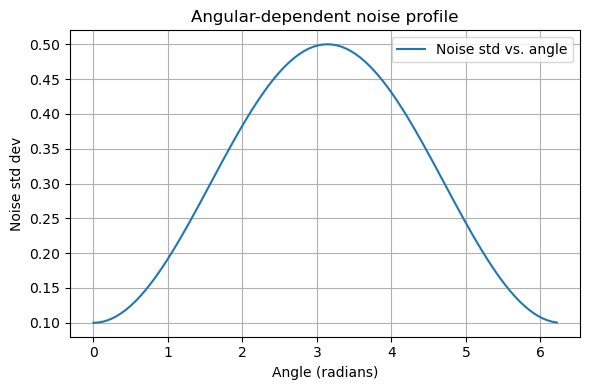

In [8]:
plt.figure(figsize=(6, 4))
plt.plot(angles, noise_profile, label='Noise std vs. angle')
plt.xlabel('Angle (radians)')
plt.ylabel('Noise std dev')
plt.title('Angular-dependent noise profile')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


2025-05-02 13:46:02.505009: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


epoch 0, Loss: 12842.966796875, normG: 747062.3125
epoch 5000, Loss: 7028.3466796875, normG: 3119035.25
epoch 10000, Loss: 3983.9658203125, normG: 157479.5625
epoch 15000, Loss: 1371.7838134765625, normG: 202241.40625
epoch 20000, Loss: -595.1399536132812, normG: 101596.078125
epoch 25000, Loss: -1644.9744873046875, normG: 47718.671875


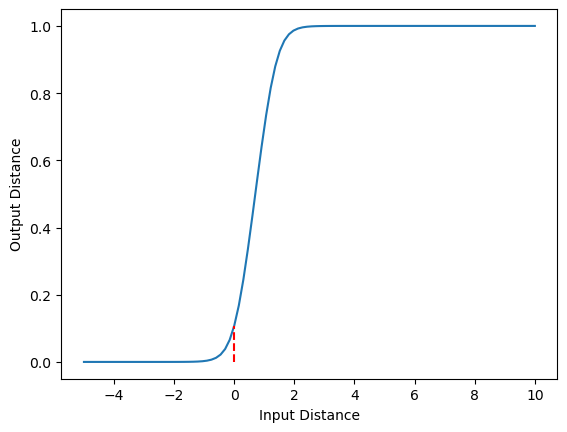

epoch 0, Loss: 12249.029296875, normG: 918917.75
epoch 5000, Loss: -2207.05126953125, normG: 3058.34521484375
epoch 10000, Loss: -2508.293212890625, normG: 10327.8896484375
epoch 15000, Loss: -2509.255615234375, normG: 13.950705528259277
epoch 20000, Loss: -2509.644287109375, normG: 22.382789611816406
epoch 25000, Loss: -2517.71484375, normG: 34.6202507019043

Metric  HMDS  BIC:    -231.87
Non‑metric BH‑MDS BIC:    -778.80


In [9]:
# ==============================================================
# Synthetic hyperbolic data with ANGULAR‑dependent correlated noise
# ==============================================================

rng = np.random.default_rng(123)          # reproducibility

# ---------- 1. sample N points in D‑dim hyperbolic space ----------
N          = 100          # number of points
D_embed    = 3            # ambient Euclidean dimension for h_samp
R_max      = 2.0          # sample up to this hyperbolic radius
pts = np.asarray([h_samp(R_max, D_embed) for _ in range(N)])

# ---------- 2. ground‑truth hyperbolic distance matrix ----------
dmat_true = np.zeros((N, N))
for i in range(N):
    for j in range(i + 1, N):
        d = pdist(pts[i], pts[j])          # hyperbolic distance
        dmat_true[i, j] = dmat_true[j, i] = d

# ---------- 3. angular coordinate & noise profile ----------
# use first two coords for θ  (works even if D_embed > 2)
angles = np.mod(np.arctan2(pts[:, 1], pts[:, 0]), 2 * np.pi)

base_sigma  = 0.05      # noise floor at θ = 0, 2π
peak_sigma  = 0.25      # extra noise added by the time θ = π
# sin²(θ/2) rises smoothly from 0 → 1 as θ: 0 → π, then falls back
noise_profile = base_sigma + peak_sigma * np.sin(angles / 2.0) ** 2

# ---------- 4. symmetric noise matrix with angular correlation ----------
noise_mat = np.zeros_like(dmat_true)
for i in range(N):
    for j in range(i + 1, N):
        # average the two point‑wise σ’s so σ_ij changes smoothly round the circle
        sigma_ij = 0.5 * (noise_profile[i] + noise_profile[j])
        eps = rng.normal(0.0, sigma_ij)
        noise_mat[i, j] = noise_mat[j, i] = eps

# ensure distances stay non‑negative
dmat_noisy = dmat_true + noise_mat
dmat_noisy[dmat_noisy < 0] = 0.0

# ==============================================================
# Metric vs NON‑metric Hyperbolic MDS on the same noisy data
# ==============================================================

D_latent      = 3     # target hyperbolic dimension in the embedding
Ns_components = 5     # mixture components for your non‑metric BH‑MDS

# ----- Metric HMDS -----
metric_model = HMDS(dmat_noisy, D_latent)
metric_model.train(n=30_000)          # adjust steps as needed
metric_bic = metric_model.BIC()

# ----- Non‑metric Bayesian HMDS -----
nm_model = nonmetricHMDS(dmat_noisy, D_latent, Ns_components)
nm_model.train(n=30_000)
nm_bic = nm_model.BIC()

print(f"\nMetric  HMDS  BIC: {metric_bic:10.2f}")
print(f"Non‑metric BH‑MDS BIC: {nm_bic:10.2f}")

# Optional quick diagnostics
# nm_model.shepard()
# metric_model.shepard()


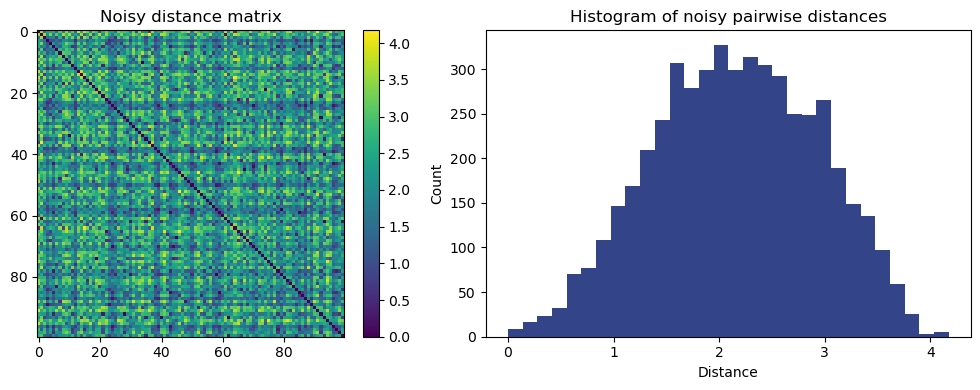

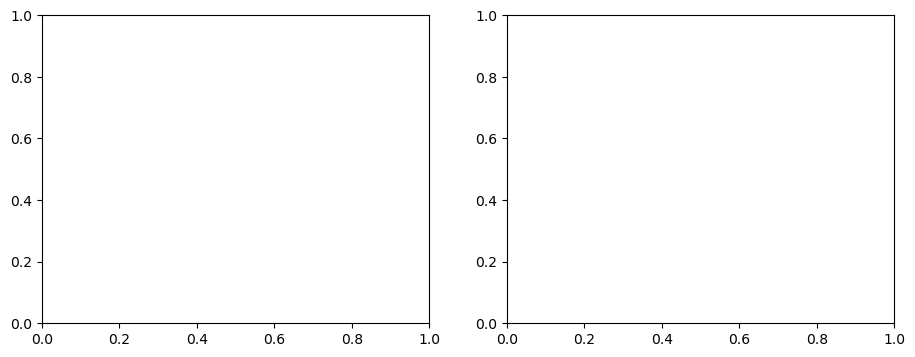

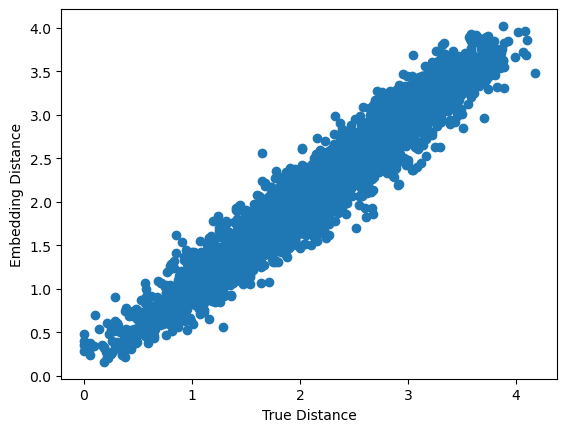

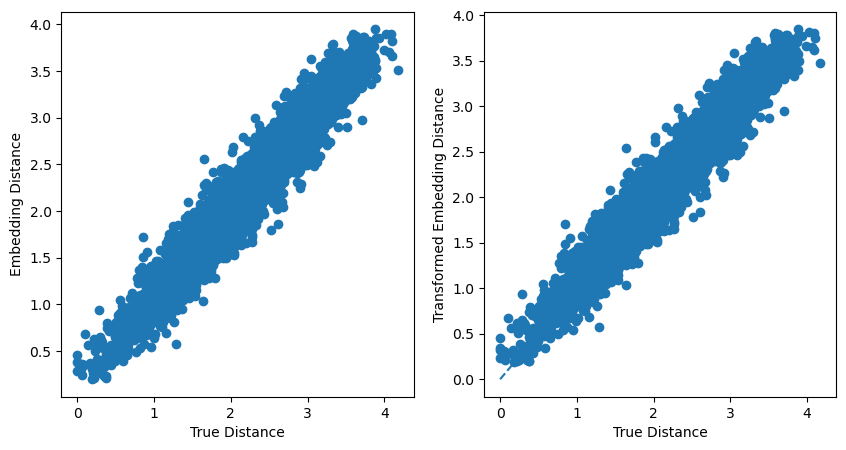

<Figure size 640x480 with 0 Axes>

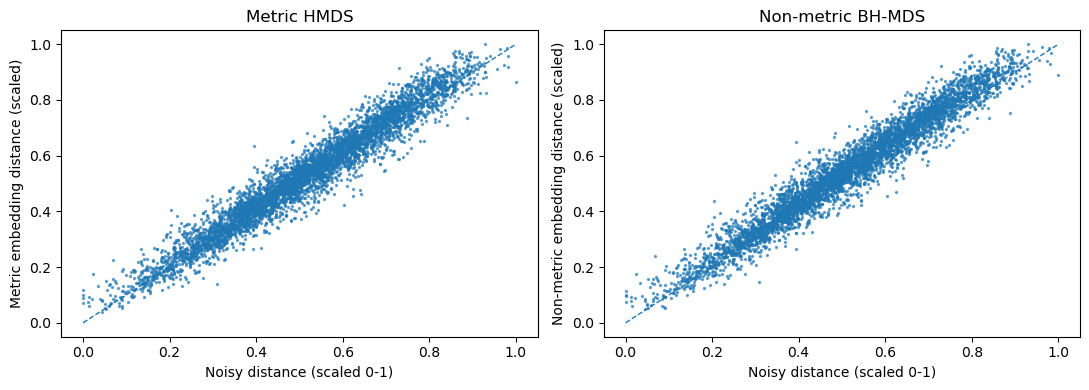

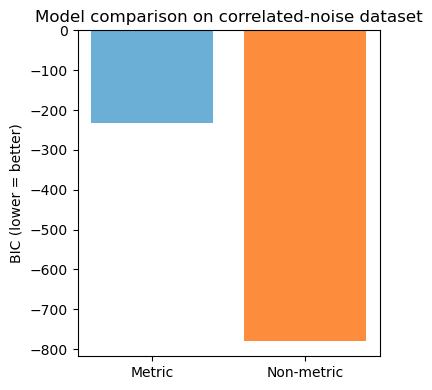

AttributeError: 'HMDS' object has no attribute 'X'

In [11]:
# ==============================================================
# Diagnostics: metric HMDS  vs  non‑metric BH‑MDS
# ==============================================================


# --------------------------------------------------------------
# helper: safe scale factor (some classes store log_lam, others don’t)
# --------------------------------------------------------------
def _scale(model):
    if hasattr(model, "log_lam"):
        return np.exp(model.log_lam)
    return 1.0

# upper‑triangular indices once
tri = np.triu_indices_from(dmat_noisy, k=1)

# embedding pairwise distances (already in hyperbolic metric)
d_emb_metric = metric_model.pairwise_dist_lorentz().numpy() / _scale(metric_model)
d_emb_nm     = nm_model    .pairwise_dist_lorentz().numpy() / _scale(nm_model)

# normalise all to [0,1] just for fair visual comparison
d_noisy  = dmat_noisy            / dmat_noisy.max()
d_metric = d_emb_metric           / d_emb_metric.max()
d_nm     = d_emb_nm               / d_emb_nm.max()

# --------------------------------------------------------------
# 1) heat‑map + histogram of the noisy distance matrix
# --------------------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(11, 4))
im = ax[0].imshow(dmat_noisy, cmap="viridis")
ax[0].set_title("Noisy distance matrix")
plt.colorbar(im, ax=ax[0], fraction=0.046, pad=0.04)

ax[1].hist(dmat_noisy[tri], bins=30, color="#334488")
ax[1].set_title("Histogram of noisy pairwise distances")
ax[1].set_xlabel("Distance")
ax[1].set_ylabel("Count")
plt.tight_layout()
plt.show()

# --------------------------------------------------------------
# 2) Shepard diagrams
# --------------------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(11, 4))

# metric
try:
    metric_model.shepard(ax=ax[0])        # works if method supports ax
except TypeError:
    metric_model.shepard()                # falls back to internal plotting
    ax[0].remove()                        # free the empty subplot slot

# non‑metric
try:
    nm_model.shepard(ax=ax[1])
except TypeError:
    nm_model.shepard()
    ax[1].remove()

plt.tight_layout()
plt.show()


# --------------------------------------------------------------
# 3) Scatter: noisy vs. embedding distances (metric & non‑metric)
# --------------------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(11, 4))
ax[0].scatter(d_noisy[tri], d_metric[tri], s=2, alpha=0.6)
ax[0].plot([0, 1], [0, 1], "--", lw=1)
ax[0].set_xlabel("Noisy distance (scaled 0‑1)")
ax[0].set_ylabel("Metric embedding distance (scaled)")
ax[0].set_title("Metric HMDS")

ax[1].scatter(d_noisy[tri], d_nm[tri], s=2, alpha=0.6)
ax[1].plot([0, 1], [0, 1], "--", lw=1)
ax[1].set_xlabel("Noisy distance (scaled 0‑1)")
ax[1].set_ylabel("Non‑metric embedding distance (scaled)")
ax[1].set_title("Non‑metric BH‑MDS")

plt.tight_layout()
plt.show()

# --------------------------------------------------------------
# 4) Quick BIC comparison bar chart
# --------------------------------------------------------------
fig, ax = plt.subplots(figsize=(4, 4))
ax.bar(["Metric", "Non‑metric"], [metric_bic, nm_bic], color=["#6baed6", "#fd8d3c"])
ax.set_ylabel("BIC (lower = better)")
ax.set_title("Model comparison on correlated‑noise dataset")
plt.tight_layout()
plt.show()

# --------------------------------------------------------------
# 5) Optional: 2‑D Poincaré scatter of the embeddings
# (works if you embedded into D_latent ≥ 2)
# --------------------------------------------------------------
if metric_model.X.shape[1] >= 2:
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].scatter(metric_model.X[:, 0], metric_model.X[:, 1], s=6, c=angles, cmap="hsv")
    ax[0].add_patch(plt.Circle((0, 0), 1, fill=False, ls="--", lw=0.8))
    ax[0].set_aspect("equal")
    ax[0].set_title("Metric HMDS embedding (Poincaré)")

    ax[1].scatter(nm_model.X[:, 0], nm_model.X[:, 1], s=6, c=angles, cmap="hsv")
    ax[1].add_patch(plt.Circle((0, 0), 1, fill=False, ls="--", lw=0.8))
    ax[1].set_aspect("equal")
    ax[1].set_title("Non‑metric BH‑MDS embedding (Poincaré)")

    for a in ax:  # hide ticks for a cleaner disc
        a.set_xticks([]); a.set_yticks([])
    plt.tight_layout()
    plt.show()
